In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>.''')

In [3]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def integrate_wrt_cdf(F, f, limits, bins):
    """
    :param F: cdf
    :param f: function to integrate w.r.t dF measure
    :param limits: tuple of integration bounds. It is assumed that F is undefined at the limit points
    :param bins: number of points on x-grid to use in integration (so, not quite the number of bins)
    """
    bin_width = (limits[1] - limits[0]) / bins  # just approximate, not the real bin width
    grid_points = np.linspace(limits[0] + bin_width/4, limits[1], num=bins, endpoint=False)
    cdf = F(grid_points)
    measure = np.diff(cdf)
    func = f(grid_points)
    return np.dot(measure, func[:-1])

In [5]:
def alpha(x, h):
    return np.log(((1-h)*np.exp(x) - h)/(1-h*(1+np.exp(x))))
def FF(x, h, T, d, sigma):
    if h<0.5:
        cum = sp.norm.cdf((alpha(x, h) - T*d)/(sigma * np.sqrt(T)))
    else:
        cum = 1 - sp.norm.cdf((alpha(x, h) - T*d)/(sigma * np.sqrt(T)))
    return cum
def ff(tau, dprime, x, sigma):
    return sp.norm.cdf(-(tau*dprime+x) / (np.sqrt(tau)*sigma))
def acc_perfect_accum(d, sigma, t):
    return sp.norm.cdf(np.abs(d)/sigma * np.sqrt(t))
def acc_perfect_accum_cp(d, sigma, T, tau):
    return sp.norm.cdf(-(abs(d)/sigma)*(T-tau)/np.sqrt(T+tau))
def acc_leak_ncp(d, sigma, T, tau, leak):
    return sp.norm.cdf(abs(d)/sigma * (1-np.exp(-leak*(T+tau))) /np.sqrt((leak/2)*(1-np.exp(-2*leak*(T+tau)))))
def acc_leak_cp(d, sigma, T, tau, leak):
    return sp.norm.cdf(abs(d)/sigma * \
                       (1 - np.exp(-leak*tau)*(2-np.exp(-leak*(T)))) \
                       / np.sqrt((leak/2)*(1-np.exp(-2*leak*(T+tau)))))

In [6]:
h=.45
T = .2
tau=.2
d=1
dprime=-1
sigma=1
t = np.arange(.001, .401, step=.001)
# t = np.concatenate([np.arange(.05, .201, step=.05),np.arange(.202,.251,step=.001), np.arange(.252,.41,step=.05)])
num_bins = 10000
a = np.log(h / (1-h))
int_lims = (min(a, -a), max(a, -a))
def FFF(x):
    return FF(x, h, T, d, sigma)

acc = []
for tt in t:
    if tt <= T:
        acc.append(acc_perfect_accum(d, sigma, tt))
    else:
        tau = tt - T
        def fff(x):
            return ff(tau, dprime, x, sigma)
        pneg = integrate_wrt_cdf(FFF, fff, int_lims, num_bins)
        if d > 0 and dprime > 0:
            acc.append(1-pneg)
        elif d > 0 and dprime < 0:
            acc.append(pneg)
        else:
            raise ValueError("no negative drift in first epoch allowed for now")

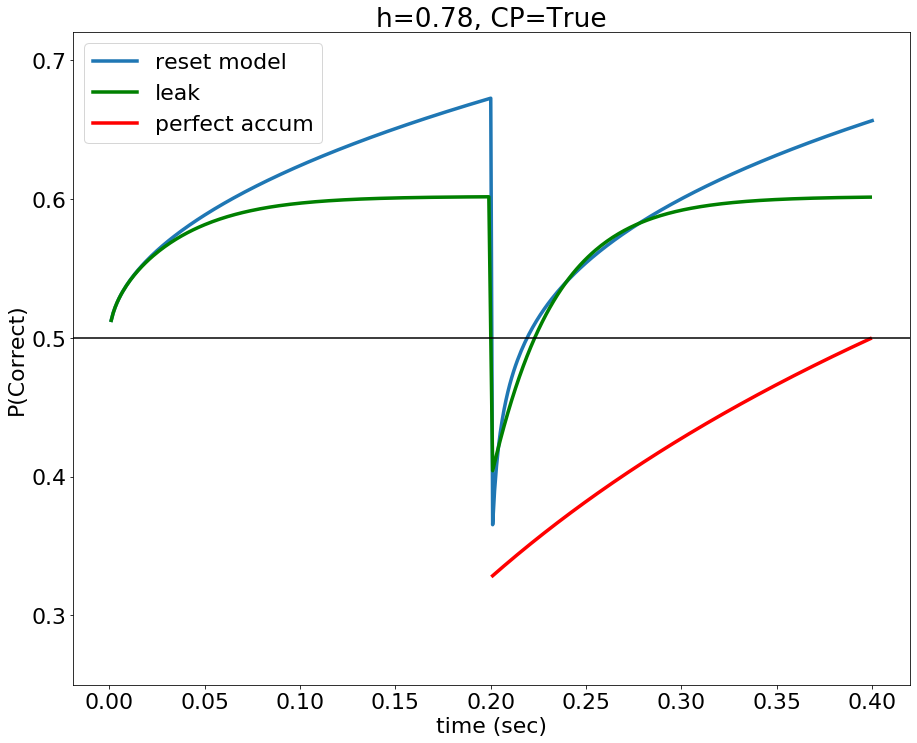

In [14]:
fig = plt.figure(figsize=(15,12))
plt.rcParams.update({'font.size': 22})
plt.plot(t, acc, linewidth=3.5, label="reset model")

# plt.plot(t, acc_perfect_accum(d, sigma, t), 'r')
ttau = np.arange(.001,.2,step=.001)
e1 = acc_leak_ncp(d, sigma, 0, ttau, 30)
e2=acc_leak_cp(d, sigma, T, ttau, 30)
plt.plot(np.concatenate([ttau,T+ttau]), np.concatenate([e1,e2]), linewidth=3.5, color='g', label="leak")
plt.plot(T+ttau, acc_perfect_accum_cp(d, sigma, T, ttau), linewidth=3.5, color='r', label="perfect accum")
plt.axhline(.5, color='k')
plt.legend()
# plt.axvline(.2, color='k')
plt.xlabel('time (sec)')
plt.ylabel('P(Correct)')
plt.ylim(0.25,.72);
is_cp = d*dprime < 0
plt.title(f'h={h}, CP={is_cp}');